In [1]:
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.metrics import pairwise_distances_chunked
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer
from sae_lens import SAE
import os
import json

import numpy as np

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/questions.csv')
df = df.sample(frac=0.001, random_state=42).reset_index(drop=True)
print(df.shape)
print(df['is_duplicate'].value_counts())

(404, 6)
is_duplicate
0    277
1    127
Name: count, dtype: int64


In [3]:
# set hf token

with open('.credentials.json') as f:
    creds = json.load(f)

os.environ['HF_TOKEN'] = creds['HF_TOKEN'] 

In [4]:
device = 'cuda'


sae_id = "blocks.12.hook_resid_post"
release = "gemma-2b-res-jb"
model_name = 'gemma-2b'
model = HookedTransformer.from_pretrained(model_name, device = device)
# sae_id = "blocks.8.hook_resid_pre"
# release = "gpt2-small-res-jb"
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = release, # see other options in sae_lens/pretrained_saes.yaml
    sae_id = sae_id,
    device = device
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Loaded pretrained model gemma-2b into HookedTransformer


In [5]:
# Assuming df is your DataFrame with 'question1' and 'question2' columns
docs = df['question1'].tolist() + df['question2'].tolist()
print(f"Total documents before deduplication: {len(docs)}")

# Remove duplicates to get unique documents
docs = list(set(docs))
print(f"Total unique documents: {len(docs)}")

Total documents before deduplication: 808
Total unique documents: 808


In [11]:
batch_size = 8

if not os.path.exists('cruft'): 
    os.makedirs('cruft')    

# remove all files in cruft

for f in os.listdir('cruft'):
    os.remove(os.path.join('cruft', f))

save_every = 5
count = 0

accumulator = None
files = []
with torch.no_grad():
    for i in range(0, len(docs), batch_size):
        print(i)
        batch = docs[i:i+batch_size]
        inputs = model.tokenizer(batch, return_tensors='pt', padding='max_length', truncation=True, max_length=90)
        _, cache = model.run_with_cache(inputs.input_ids, attention_mask=inputs.attention_mask, prepend_bos=True, stop_at_layer=18)
        f_acts = sae.encode(cache[sae.cfg.hook_name])

        if accumulator is None:
            accumulator = {
                'feature_acts': f_acts.cpu(),
                'all_att_mask': inputs.attention_mask.cpu()
            }
        else:
            accumulator['feature_acts'] = torch.cat([accumulator['feature_acts'], f_acts.cpu()], dim=0)
            accumulator['all_att_mask'] = torch.cat([accumulator['all_att_mask'], inputs.attention_mask.cpu()], dim=0)

        fname = f"cruft/feature_acts_{release}_{i}.pt"
        if i > 0 and i % save_every == 0:
            torch.save(accumulator, fname)
            files.append(fname)

            accumulator = None

if accumulator is not None:
    torch.save(accumulator, fname)
    files.append(fname)
    accumulator = None

0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800


In [12]:
def files_to_concept_documents(fnames, k=5, device='cpu'):
    cds = []
    for filename in fnames:
        data = torch.load(filename, map_location=device)
        print(filename)
        feature_acts = data['feature_acts']
        attention_mask = data['all_att_mask']

        print(feature_acts.shape)
        print(attention_mask.shape)

        cds.extend(to_concept_documents(feature_acts, attention_mask.to(torch.bool), k=k))

        print('created concept docs')

    return cds

def to_concept_documents(feature_acts, attention_mask, k=5):
    # Compute top-k indices over features for the entire batch
    topk_indices = torch.topk(feature_acts, k, dim=2).indices  # Shape: [batch_size, seq_len, k]

    print('got topk indices')
    # Prepare concept documents without inner loops
    concept_docs = []
    for i in range(feature_acts.shape[0]):
        # Select the actual tokens based on the attention mask and flatten the tensor
        tokens = topk_indices[i][attention_mask[i]].flatten()

        # Convert tokens to strings
        tokens_str = [str(idx.item()) for idx in tokens]

        # Join tokens to form the document
        concept_docs.append(" ".join(tokens_str))

    return concept_docs


def get_auc(df, docs, thresholds, cds):
    # Create a mapping from document text to index
    doc_to_index = {doc: idx for idx, doc in enumerate(docs)}

    # Map 'question1' and 'question2' to their indices
    df['q1idx'] = df['question1'].map(doc_to_index)
    df['q2idx'] = df['question2'].map(doc_to_index)

    # Build the mapping from q1idx to q2idx and vice versa
    mapping = dict(zip(df['q1idx'], df['q2idx']))
    mapping.update(zip(df['q2idx'], df['q1idx']))

    if cds is not None:
        docs = cds

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(docs)

    q1_list = np.array(list(mapping.keys()))
    q2_list = np.array([mapping[q1] for q1 in q1_list])

    query_texts = [docs[q1] for q1 in q1_list]
    query_vectors = vectorizer.transform(query_texts)

    results = []

    batch_size = 10_000  # Adjust this based on your memory constraints

    for threshold in thresholds:
        n_queries = query_vectors.shape[0]
        n_batches = int(np.ceil(n_queries / batch_size))
        n_above_threshold_total = np.zeros(n_queries, dtype=int)
        n_correct_above_threshold_total = np.zeros(n_queries, dtype=int)
        
        for batch_idx in range(n_batches):
            start = batch_idx * batch_size
            end = min((batch_idx + 1) * batch_size, n_queries)
            
            query_batch = query_vectors[start:end]
            
            chunk_generator = pairwise_distances_chunked(
                X=query_batch,
                Y=tfidf_matrix,
                metric='cosine',
                n_jobs=-1,
                working_memory=2048 # Adjust this based on your system
            )
            
            for chunk in chunk_generator:
                cosine_sim_batch = 1 - chunk
                
                for i in range(cosine_sim_batch.shape[0]):
                    idx = start + i
                    sim_scores = cosine_sim_batch[i]
                    
                    n_above = np.sum(sim_scores > threshold)
                    n_above_threshold_total[idx] = n_above
                    
                    correct_doc_idx = q2_list[idx]
                    correct_sim = sim_scores[correct_doc_idx]
                    n_correct_above = int(correct_sim > threshold)
                    n_correct_above_threshold_total[idx] = n_correct_above
                    
        with np.errstate(divide='ignore', invalid='ignore'):
            scores = np.divide(
                n_correct_above_threshold_total,
                n_above_threshold_total,
                where=n_above_threshold_total > 0
            )
            scores[n_above_threshold_total == 0] = 0

        # Compute average score for the current threshold
        avg_score = np.mean(scores)
        results.append(avg_score)
    return results


In [13]:
files = ['cruft/' + f for f in os.listdir('./cruft/') if f[-3:] == '.pt']
files = sorted(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
print(files)

['cruft/feature_acts_gemma-2b-res-jb_40.pt', 'cruft/feature_acts_gemma-2b-res-jb_80.pt', 'cruft/feature_acts_gemma-2b-res-jb_120.pt', 'cruft/feature_acts_gemma-2b-res-jb_160.pt', 'cruft/feature_acts_gemma-2b-res-jb_200.pt', 'cruft/feature_acts_gemma-2b-res-jb_240.pt', 'cruft/feature_acts_gemma-2b-res-jb_280.pt', 'cruft/feature_acts_gemma-2b-res-jb_320.pt', 'cruft/feature_acts_gemma-2b-res-jb_360.pt', 'cruft/feature_acts_gemma-2b-res-jb_400.pt', 'cruft/feature_acts_gemma-2b-res-jb_440.pt', 'cruft/feature_acts_gemma-2b-res-jb_480.pt', 'cruft/feature_acts_gemma-2b-res-jb_520.pt', 'cruft/feature_acts_gemma-2b-res-jb_560.pt', 'cruft/feature_acts_gemma-2b-res-jb_600.pt', 'cruft/feature_acts_gemma-2b-res-jb_640.pt', 'cruft/feature_acts_gemma-2b-res-jb_680.pt', 'cruft/feature_acts_gemma-2b-res-jb_720.pt', 'cruft/feature_acts_gemma-2b-res-jb_760.pt', 'cruft/feature_acts_gemma-2b-res-jb_800.pt']


In [14]:
rs = []
ks = [None, 1]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]

for k in ks:
    if k is None:
        cds2 = None
    else:
        cds = files_to_concept_documents(files, k=k, device='cuda')
        print('concept documents', cds[:2])
        cds2 = cds

        
    results = get_auc(df, docs, thresholds, cds=cds2)
    print('got results')

    rs.append(results)

got results
cruft/feature_acts_gemma-2b-res-jb_40.pt
torch.Size([48, 90, 16384])
torch.Size([48, 90])
got topk indices


/tmp/ipykernel_36306/1726404123.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(filename, map_location=device)


created concept docs
cruft/feature_acts_gemma-2b-res-jb_80.pt
torch.Size([40, 90, 16384])
torch.Size([40, 90])
got topk indices
created concept docs
cruft/feature_acts_gemma-2b-res-jb_120.pt
torch.Size([40, 90, 16384])
torch.Size([40, 90])
got topk indices
created concept docs
cruft/feature_acts_gemma-2b-res-jb_160.pt
torch.Size([40, 90, 16384])
torch.Size([40, 90])
got topk indices
created concept docs
cruft/feature_acts_gemma-2b-res-jb_200.pt
torch.Size([40, 90, 16384])
torch.Size([40, 90])
got topk indices
created concept docs
cruft/feature_acts_gemma-2b-res-jb_240.pt
torch.Size([40, 90, 16384])
torch.Size([40, 90])
got topk indices
created concept docs
cruft/feature_acts_gemma-2b-res-jb_280.pt
torch.Size([40, 90, 16384])
torch.Size([40, 90])
got topk indices
created concept docs
cruft/feature_acts_gemma-2b-res-jb_320.pt
torch.Size([40, 90, 16384])
torch.Size([40, 90])
got topk indices
created concept docs
cruft/feature_acts_gemma-2b-res-jb_360.pt
torch.Size([40, 90, 16384])
torch.S

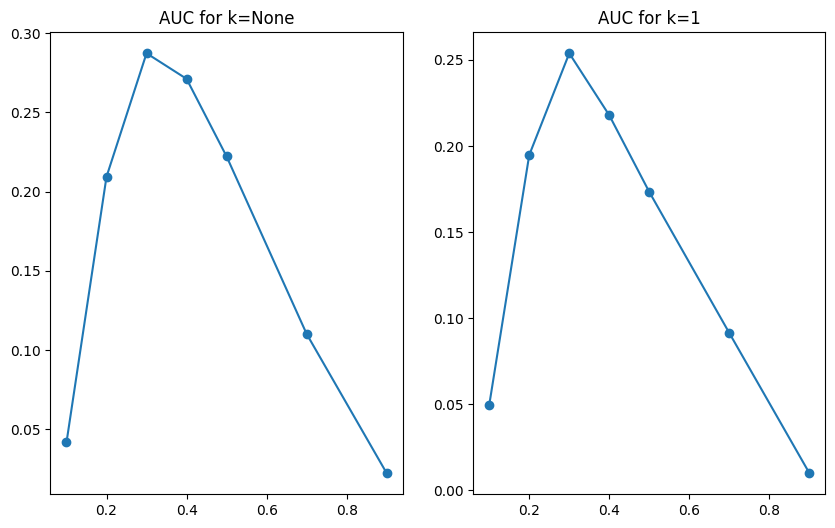

In [15]:
f, ax = plt.subplots(1, len(rs), figsize=(10, 6))

# 0.035
for i, r in enumerate(rs):
    ax[i].plot(thresholds, r, marker='o')
    ax[i].set_title(f"AUC for k={ks[i]}")

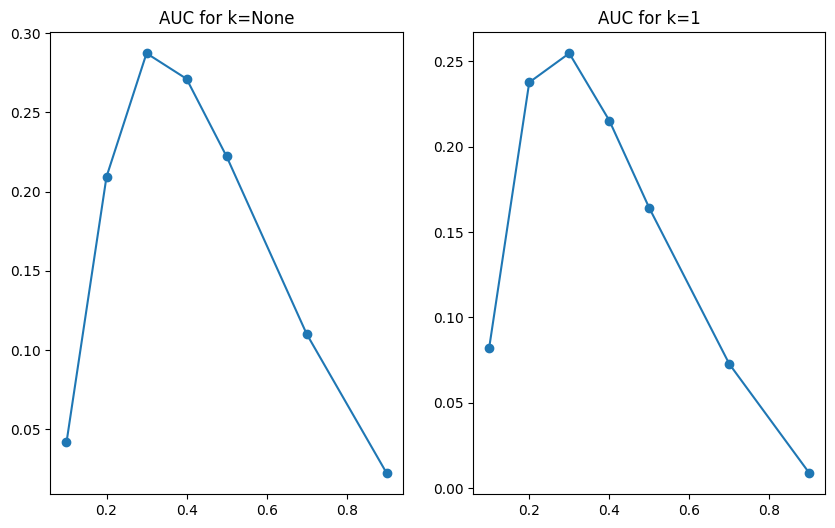

In [11]:
f, ax = plt.subplots(1, len(rs), figsize=(10, 6))

# 0.035
for i, r in enumerate(rs):
    ax[i].plot(thresholds, r, marker='o')
    ax[i].set_title(f"AUC for k={ks[i]}")

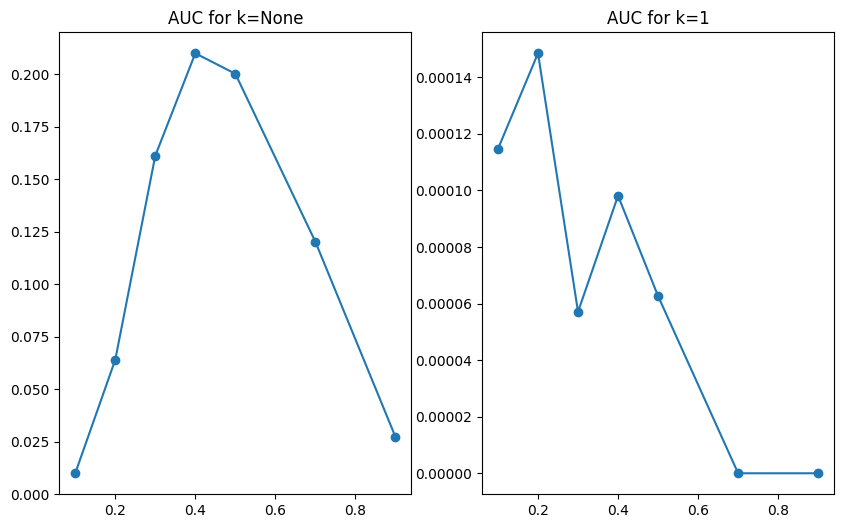

In [7]:
f, ax = plt.subplots(1, len(rs), figsize=(10, 6))

# 0.035
for i, r in enumerate(rs):
    ax[i].plot(thresholds, r, marker='o')
    ax[i].set_title(f"AUC for k={ks[i]}")

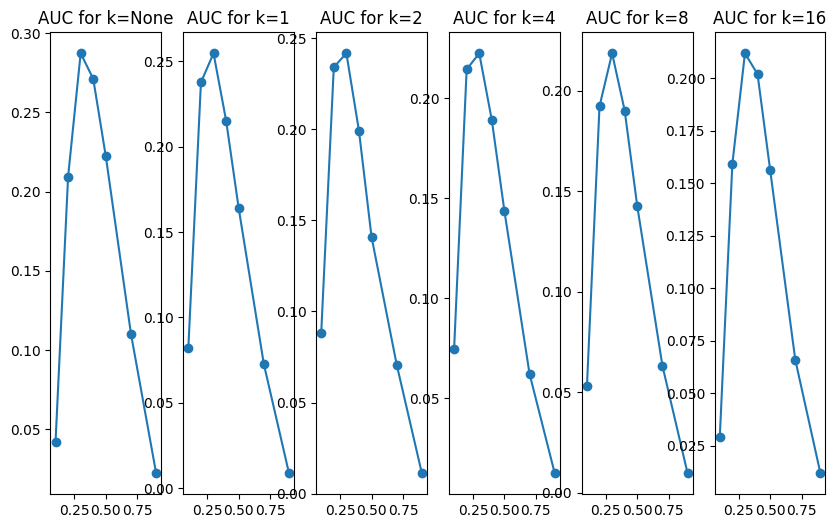

In [72]:
f, ax = plt.subplots(1, len(rs), figsize=(10, 6))

# 0.035
for i, r in enumerate(rs):
    ax[i].plot(thresholds, r, marker='o')
    ax[i].set_title(f"AUC for k={ks[i]}")